In [1]:
from __init__ import *
import pandas as pd
import os
import ast
from matplotlib.collections import PatchCollection
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np

In [2]:

class MulticolorPatch(object):
    def __init__(self, colors, alphas):
        self.colors = colors
        self.alphas = alphas
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height, 
                           facecolor=c, 
                           edgecolor='none', alpha=orig_handle.alphas[i]))

        patch = PatchCollection(patches,match_original=True)

        handlebox.add_artist(patch)
        return patch

# mAP50-95 performance metrics

In [42]:
# read file from csv
cutout_file_name = "rb20563a"
df_cutout = pd.read_csv(f'../../data/wandb/{cutout_file_name}.csv')
print(f"Number of complete runs sweep {cutout_file_name}: {len(df_cutout)}")
cutout_names = df_cutout['name'].unique()

whole_file_name = "nvowmnfu"
df_whole = pd.read_csv(f'../../data/wandb/{whole_file_name}.csv')
print(f"Number of complete runs sweep {whole_file_name}: {len(df_whole)}")
whole_names = df_whole['name'].unique()

all_data_file_name = "project"
df = pd.read_csv(f'../../data/wandb/{all_data_file_name}.csv')

Number of complete runs sweep rb20563a: 84
Number of complete runs sweep nvowmnfu: 95


In [43]:
# Check if whole_names and whole_names have some of the same names
# If they do, report them
common_names = set(whole_names).intersection(set(cutout_names))
if len(common_names) > 0:
    print(f"Common names between whole and cutout: {common_names}")

Common names between whole and cutout: {'noble-sweep-67'}


## Split name into sweep name and fold

In [44]:
# based on the name column, extract the base sweep name and the sweep number for each row
df['sweep_name'] = df['name'].apply(lambda x: "-".join(x.split('-')[:3]))
df['fold_number'] = df['name'].apply(lambda x: x.split('-')[3] if len(x.split('-')) == 4 else None)
df.head()

,Unnamed: 0,summary,config,name,sweep_name,fold_number
0,0,{'_wandb': {'runtime': 0}},"{'lr': 0.004458700064643615, 'imgsz': 525, 'op...",warm-sweep-8,warm-sweep-8,None
1,1,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.004458700064643615, 'imgsz': 525, 'op...",warm-sweep-8-0,warm-sweep-8,0
2,2,{'_wandb': {'runtime': 1}},"{'lr': 0.005368920157058689, 'imgsz': 346, 'op...",zesty-sweep-9,zesty-sweep-9,None
3,3,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.005368920157058689, 'imgsz': 346, 'op...",zesty-sweep-9-0,zesty-sweep-9,0
4,4,{'_wandb': {'runtime': 0}},"{'lr': 0.009433873678785136, 'imgsz': 480, 'op...",morning-sweep-10,morning-sweep-10,None


### Add tag to distinguish between the different sweeps

In [45]:
# add tag column to the dataframes, if sweep_name is in cutout_names, then tag is cutout, if sweep_name is in whole_names, then tag is whole
df['tag'] = df['sweep_name'].apply(lambda x: "chute" if x in cutout_names else "straw" if x in whole_names else None)
# remove rows with tag None
df = df[df['tag'].notnull()]
df.head()

,Unnamed: 0,summary,config,name,sweep_name,fold_number,tag
104,104,{'_wandb': {'runtime': 0}},"{'lr': 0.009567376268786183, 'imgsz': 538, 'op...",dainty-sweep-24,dainty-sweep-24,None,chute
105,105,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.009567376268786183, 'imgsz': 538, 'op...",dainty-sweep-24-0,dainty-sweep-24,0,chute
110,110,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.009567376268786183, 'imgsz': 538, 'op...",dainty-sweep-24-1,dainty-sweep-24,1,chute
117,117,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.009567376268786183, 'imgsz': 538, 'op...",dainty-sweep-24-2,dainty-sweep-24,2,chute
123,123,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.009567376268786183, 'imgsz': 538, 'op...",dainty-sweep-24-3,dainty-sweep-24,3,chute


### Check to make sure all folds for each run in the sweeps exist

In [46]:
# # go through dataframe, and make sure that each sweep_name has a row with None, 0, 1, 2, 3, 4 for sweep_number
# # Checking for missing folds for each run in the dataframe
# for sweep_name in df['sweep_name'].unique():
#     for sweep_number in range(5):
#         # check if {sweep_name}-{sweep_number} is in name column of the dataframe
#         val = "-".join([sweep_name, str(sweep_number)])
#         if val not in df['name'].values:
#             print(f"Missing sweep {val}")

#### Add the desired metrics as columns

In [47]:
# first drop the rows with fold_number None
df = df[df['fold_number'].notnull()]
# sort the dataframes by sweep_name and sweep_number
df = df.sort_values(by=['sweep_name', 'fold_number']).reset_index(drop=True)

metrics = ['test/mAP50-95(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', "_runtime"]
# for each row we retrieve the summary, make it into a dictionary, and then extract the metrics
for metric in metrics:
    df[metric] = df['summary'].apply(
        lambda x: ast.literal_eval(x).get(metric, None) if isinstance(x, str) else None
    )
df.head()

,Unnamed: 0,summary,config,name,sweep_name,fold_number,tag,test/mAP50-95(B),metrics/mAP50(B),metrics/mAP50-95(B),_runtime
0,1626,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.00011988827124698378, 'imgsz': 448, '...",ancient-sweep-49-0,ancient-sweep-49,0,straw,0.609798,0.950380,0.868736,2185.340187
1,1637,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.00011988827124698378, 'imgsz': 448, '...",ancient-sweep-49-1,ancient-sweep-49,1,straw,0.613523,0.959655,0.880316,1835.257155
2,1650,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.00011988827124698378, 'imgsz': 448, '...",ancient-sweep-49-2,ancient-sweep-49,2,straw,0.607671,0.964678,0.879971,1998.346413
3,1662,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.00011988827124698378, 'imgsz': 448, '...",ancient-sweep-49-3,ancient-sweep-49,3,straw,0.684034,0.962055,0.892171,2018.219162
4,2120,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.006118152295846874, 'imgsz': 608, 'op...",ancient-sweep-64-0,ancient-sweep-64,0,chute,0.796000,0.984166,0.982292,3197.084218


### Now we remove incomplete runs

In [48]:
# Remove all rows if the number of rows with sweep_name is less than 5
df = df.groupby('sweep_name').filter(lambda x: len(x) == 4)
df.head()

,Unnamed: 0,summary,config,name,sweep_name,fold_number,tag,test/mAP50-95(B),metrics/mAP50(B),metrics/mAP50-95(B),_runtime
0,1626,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.00011988827124698378, 'imgsz': 448, '...",ancient-sweep-49-0,ancient-sweep-49,0,straw,0.609798,0.950380,0.868736,2185.340187
1,1637,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.00011988827124698378, 'imgsz': 448, '...",ancient-sweep-49-1,ancient-sweep-49,1,straw,0.613523,0.959655,0.880316,1835.257155
2,1650,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.00011988827124698378, 'imgsz': 448, '...",ancient-sweep-49-2,ancient-sweep-49,2,straw,0.607671,0.964678,0.879971,1998.346413
3,1662,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.00011988827124698378, 'imgsz': 448, '...",ancient-sweep-49-3,ancient-sweep-49,3,straw,0.684034,0.962055,0.892171,2018.219162
4,2120,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.006118152295846874, 'imgsz': 608, 'op...",ancient-sweep-64-0,ancient-sweep-64,0,chute,0.796000,0.984166,0.982292,3197.084218


## Create dataframes for each of the two datasets

In [53]:
chute_sweep = df[df['tag'] == 'chute'].reset_index(drop=True)
straw_sweep = df[df['tag'] == 'straw'].reset_index(drop=True)

In [54]:
# check for duplicates in the dataframes
print(f"Number of duplicates in chute_sweep: {chute_sweep.duplicated().sum()}")
print(f"Number of duplicates in straw_sweep: {straw_sweep.duplicated().sum()}")

Number of duplicates in chute_sweep: 0
Number of duplicates in straw_sweep: 0


## CHUTE

In [69]:
# create a new dataframe that for each sweep_name has the average of the metrics across the 5 folds together with a std
chute_sweep_avg = chute_sweep.groupby('sweep_name').agg(
    # mAP50_B_avg=('metrics/mAP50(B)', 'mean'),
    # mAP50_B_std=('metrics/mAP50(B)', 'std'),
    # mAP50_B_max=('metrics/mAP50(B)', 'max'),
    # mAP50_B_min=('metrics/mAP50(B)', 'min'),
    mAP50_95_B_avg=('test/mAP50-95(B)', 'mean'),
    # mAP50_95_B_std=('metrics/mAP50-95(B)', 'std'),
    # mAP50_95_B_min=('metrics/mAP50-95(B)', 'min'),
    # mAP50_95_B_max=('metrics/mAP50-95(B)', 'max'),
).reset_index()

# to each row add the metric for each fold as a column
for i in range(4):
    chute_sweep_avg[f'mAP50_95_B_fold_{i}'] = chute_sweep_avg['sweep_name'].apply(
        lambda x: chute_sweep[(chute_sweep['sweep_name'] == x) & (chute_sweep['fold_number'] == str(i))]['test/mAP50-95(B)'].values[0]
    )


# now we sort the new dataframe by the average of the mAP50-95(B) metric in descending order
chute_sweep_avg = chute_sweep_avg.sort_values(by='mAP50_95_B_avg', ascending=False).reset_index(drop=True)
# round the values to 3 decimal places
chute_sweep_avg = chute_sweep_avg.round(3)
chute_sweep_avg.head(5)

,sweep_name,mAP50_95_B_avg,mAP50_95_B_fold_0,mAP50_95_B_fold_1,mAP50_95_B_fold_2,mAP50_95_B_fold_3
0,grateful-sweep-33,0.804,0.796,0.790,0.833,0.796
1,swept-sweep-73,0.796,0.796,0.796,0.796,0.796
2,azure-sweep-16,0.796,0.796,0.796,0.796,0.796
3,serene-sweep-57,0.796,0.796,0.796,0.796,0.796
4,true-sweep-64,0.796,0.796,0.796,0.796,0.796


In [60]:
len(chute_sweep_avg)

65

In [61]:
# plot top two chute_sweep_avg with sweep_name as label, and then plot each of the fold metrics as a line
# plot the average of the metrics for each sweep_name
import matplotlib.pyplot as plt
import seaborn as sns

# Extract data points for the top two sweep_names
chute_sweep_avg_topx = chute_sweep_avg.head(4)
chute_sweep_avg_topx = chute_sweep_avg_topx.melt(
    id_vars=['sweep_name', 'mAP50_95_B_avg'],
    value_vars=[f'mAP50_95_B_fold_{i}' for i in range(4)],
    var_name='fold',
    value_name='mAP50_95_B'
)

chute_sweep_avg_topx

,sweep_name,mAP50_95_B_avg,fold,mAP50_95_B
0,grateful-sweep-33,0.804,mAP50_95_B_fold_0,0.796
1,swept-sweep-73,0.796,mAP50_95_B_fold_0,0.796
2,azure-sweep-16,0.796,mAP50_95_B_fold_0,0.796
3,serene-sweep-57,0.796,mAP50_95_B_fold_0,0.796
4,grateful-sweep-33,0.804,mAP50_95_B_fold_1,0.790
5,swept-sweep-73,0.796,mAP50_95_B_fold_1,0.796
6,azure-sweep-16,0.796,mAP50_95_B_fold_1,0.796
7,serene-sweep-57,0.796,mAP50_95_B_fold_1,0.796
8,grateful-sweep-33,0.804,mAP50_95_B_fold_2,0.833
9,swept-sweep-73,0.796,mAP50_95_B_fold_2,0.796


C:\Users\Dennis\AppData\Local\Temp\ipykernel_26840\2725062486.py:12: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.boxplot(


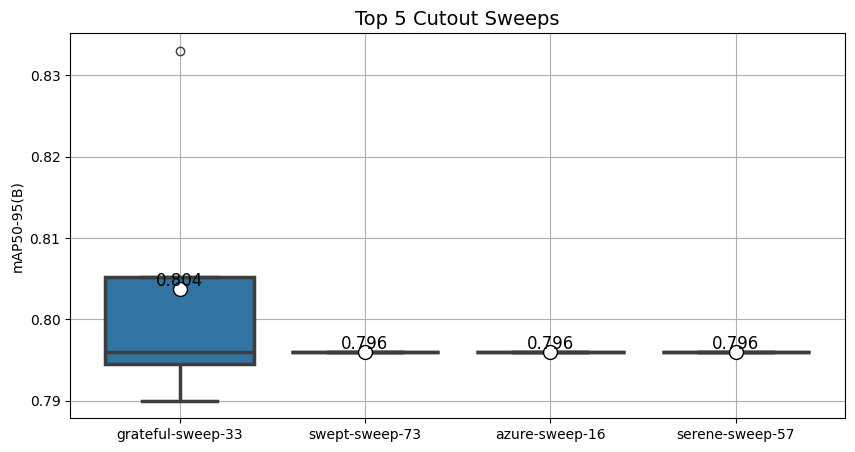

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define custom colors for each sweep
palette = sns.color_palette("tab10", n_colors=5)  # Unique colors for each sweep

# Create figure
plt.figure(figsize=(10, 5))

# Create a box plot WITHOUT showmeans
sns.boxplot(
    data=chute_sweep_avg_topx, x='sweep_name', y='mAP50_95_B', hue='sweep_name',
    palette=palette, linewidth=2.5, showmeans=False, showfliers=True
)

# Calculate and manually plot the means to avoid Seaborn's issue
sweep_names = chute_sweep_avg_topx['sweep_name'].unique()
for i, sweep in enumerate(sweep_names):
    subset = chute_sweep_avg_topx[chute_sweep_avg_topx['sweep_name'] == sweep]
    mean_value = np.mean(subset['mAP50_95_B'])  # Compute the mean for this sweep
    plt.scatter(i, mean_value, color='white', edgecolors='black', s=100, zorder=3)  # Custom mean marker
    # add the mean value to the plot
    plt.text(i, mean_value-0.00015, f'{mean_value:.3f}', ha='center', va='bottom', fontsize=12)

# Title and labels
plt.title("Top 5 Cutout Sweeps", fontsize=14)
plt.xlabel('')
plt.ylabel('mAP50-95(B)')
plt.grid()

# Show plot
plt.show()


In [63]:
# extract the config from df based on the sweep_name from the top 1 in chute_sweep_avg
for i in range(5):
    chute_sweep_avg_top1 = chute_sweep_avg.iloc[i]
    cutout_top1_config = df[df['sweep_name'] == chute_sweep_avg_top1['sweep_name']].iloc[0]['config']
    print(f"Top {i+1} cutout sweep config: {cutout_top1_config}")

Top 1 cutout sweep config: {'lr': 0.0004348852257812926, 'imgsz': 320, 'optimizer': 'Adam', 'batch_size': 21}
Top 2 cutout sweep config: {'lr': 0.006810845332084109, 'imgsz': 128, 'optimizer': 'AdamW', 'batch_size': 8}
Top 3 cutout sweep config: {'lr': 0.005161083585009989, 'imgsz': 480, 'optimizer': 'Adam', 'batch_size': 14}
Top 4 cutout sweep config: {'lr': 0.0012260034359926246, 'imgsz': 128, 'optimizer': 'Adam', 'batch_size': 22}
Top 5 cutout sweep config: {'lr': 0.008182627982129776, 'imgsz': 224, 'optimizer': 'Adam', 'batch_size': 19}


## WHOLE

In [64]:
# create a new dataframe that for each sweep_name has the average of the metrics across the 5 folds together with a std
straw_sweep_avg = straw_sweep.groupby('sweep_name').agg(
    # mAP50_B_avg=('metrics/mAP50(B)', 'mean'),
    # mAP50_B_std=('metrics/mAP50(B)', 'std'),
    # mAP50_B_max=('metrics/mAP50(B)', 'max'),
    # mAP50_B_min=('metrics/mAP50(B)', 'min'),
    mAP50_95_B_avg=('test/mAP50-95(B)', 'mean'),
    # mAP50_95_B_std=('metrics/mAP50-95(B)', 'std'),
    # mAP50_95_B_min=('metrics/mAP50-95(B)', 'min'),
    # mAP50_95_B_max=('metrics/mAP50-95(B)', 'max'),
).reset_index()

# to each row add the metric for each fold as a column
for i in range(4):
    straw_sweep_avg[f'mAP50_95_B_fold_{i}'] = straw_sweep_avg['sweep_name'].apply(
        lambda x: straw_sweep[(straw_sweep['sweep_name'] == x) & (straw_sweep['fold_number'] == str(i))]['test/mAP50-95(B)'].values[0]
    )

# now we sort the new dataframe by the average of the mAP50-95(B) metric in descending order
straw_sweep_avg = straw_sweep_avg.sort_values(by='mAP50_95_B_avg', ascending=False).reset_index(drop=True)
# round the values in the dataframe to 3 decimal places
straw_sweep_avg = straw_sweep_avg.round(3)
straw_sweep_avg.head()

,sweep_name,mAP50_95_B_avg,mAP50_95_B_fold_0,mAP50_95_B_fold_1,mAP50_95_B_fold_2,mAP50_95_B_fold_3
0,dazzling-sweep-38,0.768,0.743,0.765,0.776,0.788
1,fresh-sweep-8,0.755,0.724,0.759,0.761,0.774
2,rare-sweep-54,0.745,0.757,0.779,0.711,0.733
3,iconic-sweep-78,0.732,0.695,0.733,0.729,0.771
4,young-sweep-11,0.731,0.729,0.750,0.730,0.715


In [65]:
len(straw_sweep_avg)

78

In [66]:
# plot top two straw_sweep_avg with sweep_name as label, and then plot each of the fold metrics as a line
# plot the average of the metrics for each sweep_name
import matplotlib.pyplot as plt
import seaborn as sns

# Extract data points for the top two sweep_names
straw_sweep_avg_topx = straw_sweep_avg.head(4)
straw_sweep_avg_topx = straw_sweep_avg_topx.melt(
    id_vars=['sweep_name', 'mAP50_95_B_avg'],
    value_vars=[f'mAP50_95_B_fold_{i}' for i in range(4)],
    var_name='fold',
    value_name='mAP50_95_B'
)

straw_sweep_avg_topx

,sweep_name,mAP50_95_B_avg,fold,mAP50_95_B
0,dazzling-sweep-38,0.768,mAP50_95_B_fold_0,0.743
1,fresh-sweep-8,0.755,mAP50_95_B_fold_0,0.724
2,rare-sweep-54,0.745,mAP50_95_B_fold_0,0.757
3,iconic-sweep-78,0.732,mAP50_95_B_fold_0,0.695
4,dazzling-sweep-38,0.768,mAP50_95_B_fold_1,0.765
5,fresh-sweep-8,0.755,mAP50_95_B_fold_1,0.759
6,rare-sweep-54,0.745,mAP50_95_B_fold_1,0.779
7,iconic-sweep-78,0.732,mAP50_95_B_fold_1,0.733
8,dazzling-sweep-38,0.768,mAP50_95_B_fold_2,0.776
9,fresh-sweep-8,0.755,mAP50_95_B_fold_2,0.761


C:\Users\Dennis\AppData\Local\Temp\ipykernel_26840\3309124804.py:12: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.boxplot(


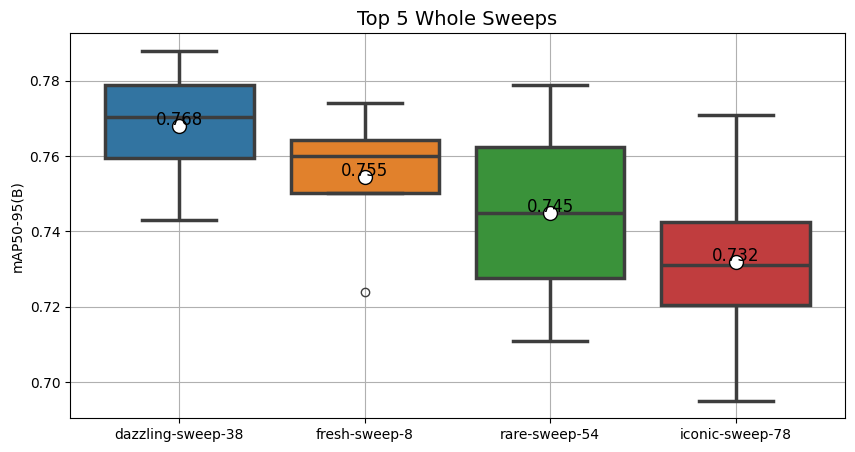

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define custom colors for each sweep
palette = sns.color_palette("tab10", n_colors=5)  # Unique colors for each sweep

# Create figure
plt.figure(figsize=(10, 5))

# Create a box plot WITHOUT showmeans
sns.boxplot(
    data=straw_sweep_avg_topx, x='sweep_name', y='mAP50_95_B', hue='sweep_name',
    palette=palette, linewidth=2.5, showmeans=False, showfliers=True
)

# Calculate and manually plot the means to avoid Seaborn's issue
sweep_names = straw_sweep_avg_topx['sweep_name'].unique()
for i, sweep in enumerate(sweep_names):
    subset = straw_sweep_avg_topx[straw_sweep_avg_topx['sweep_name'] == sweep]
    mean_value = np.mean(subset['mAP50_95_B'])  # Compute the mean for this sweep
    plt.scatter(i, mean_value, color='white', edgecolors='black', s=100, zorder=3)  # Custom mean marker
    # add the mean value to the plot with a background behgind the text
    plt.text(i, mean_value-0.0008, f'{mean_value:.3f}', ha='center', va='bottom', fontsize=12)
    # plot a rectangle behind the text for visibility
    # plt.gca().add_patch(plt.Rectangle((i, mean_value-0.0015), 0.1, 0.00075, fill=True, color='white', zorder=2))
    
# Title and labels
plt.title("Top 5 Whole Sweeps", fontsize=14)
plt.xlabel('')
plt.ylabel('mAP50-95(B)')
plt.grid()

# Show plot
plt.show()


In [68]:
# extract the config from df based on the sweep_name from the top 1 in chute_sweep_avg
for i in range(50):
    straw_sweep_avg_top1 = straw_sweep_avg.iloc[i]
    whole_top1_config = df[df['sweep_name'] == straw_sweep_avg_top1['sweep_name']].iloc[0]['config']
    print(f"Top {i+1} whole sweep config: {whole_top1_config}")

Top 1 whole sweep config: {'lr': 0.004602080921713371, 'imgsz': 224, 'optimizer': 'SGD', 'batch_size': 32}
Top 2 whole sweep config: {'lr': 0.00023016007057074375, 'imgsz': 256, 'optimizer': 'Adam', 'batch_size': 27}
Top 3 whole sweep config: {'lr': 0.00812541176458775, 'imgsz': 256, 'optimizer': 'AdamW', 'batch_size': 30}
Top 4 whole sweep config: {'lr': 0.003905352939789463, 'imgsz': 256, 'optimizer': 'AdamW', 'batch_size': 25}
Top 5 whole sweep config: {'lr': 0.009081321777714669, 'imgsz': 224, 'optimizer': 'SGD', 'batch_size': 27}
Top 6 whole sweep config: {'lr': 0.008497225768541877, 'imgsz': 192, 'optimizer': 'Adam', 'batch_size': 17}
Top 7 whole sweep config: {'lr': 0.0011817487910386834, 'imgsz': 160, 'optimizer': 'AdamW', 'batch_size': 14}
Top 8 whole sweep config: {'lr': 0.0019121676298324763, 'imgsz': 160, 'optimizer': 'AdamW', 'batch_size': 29}
Top 9 whole sweep config: {'lr': 0.0035392554723773567, 'imgsz': 192, 'optimizer': 'SGD', 'batch_size': 10}
Top 10 whole sweep conf

# Loss curves

In [136]:
# read file from csv
loss_names = ["train_box.csv", "train_cls.csv", "train_dfl.csv", "val_box.csv", "val_cls.csv", "val_dfl.csv", "map50.csv", "map5095.csv"]
dir_names = ["grateful"]
data_dir = "../../data/wandb"

In [137]:
# We wish to create a dataframe that contains 5 columns, index, dir_name, box, cls, dfl

# create a list of dataframes, each dataframe is a dir name with the loss names as columns
dfs = []
for dir_name in dir_names:
    dfs_dir = []
    for loss_name in loss_names:
        df = pd.read_csv(f'{data_dir}/{dir_name}/{loss_name}')
        if loss_name == "map5095.csv":
            # rename any column with /mAP50-95(B) to have /mAP5095 instead
            df.columns = [col.replace("/mAP50-95(B)", "/mAP5095") for col in df.columns]

        df['dir_name'] = dir_name
        dfs_dir.append(df)
    dfs.append(pd.concat(dfs_dir, axis=1))

df1 = dfs[0]
# df2 = dfs[1]

df1 = df1.drop(columns=['dir_name'])
# df2 = df2.drop(columns=['dir_name'])

# rename step to epoch
df1.rename(columns={'Step': 'Epoch'}, inplace=True)
# df2.rename(columns={'Step': 'Epoch'}, inplace=True)

new_names_df1 = []
for col in df1.columns:
    if col == 'Epoch':
        new_names_df1.append(col)
    else:
        if "MIN" in col:
            name = col.split(" - ")[0].split("-")[-1] + "_" + col.split(" - ")[1].split("__")[0]
            new_names_df1.append(f"{name}_MIN")
        elif "MAX" in col:
            name = col.split(" - ")[0].split("-")[-1] + "_" + col.split(" - ")[1].split("__")[0]
            new_names_df1.append(f"{name}_MAX")
        else:
            new_names_df1.append("".join("_".join(col.split('-')[-2:]).split(" ")))

# new_names_df2 = []
# for col in df2.columns:
#     if col == 'Epoch':
#         new_names_df2.append(col)
#     else:
#         if "MIN" in col:
#             name = col.split(" - ")[0].split("-")[-1] + "_" + col.split(" - ")[1].split("__")[0]
#             new_names_df2.append(f"{name}_MIN")
#         elif "MAX" in col:
#             name = col.split(" - ")[0].split("-")[-1] + "_" + col.split(" - ")[1].split("__")[0]
#             new_names_df2.append(f"{name}_MAX")
#         else:
#             new_names_df2.append("".join("_".join(col.split('-')[-2:]).split(" ")))

# rename the columns
df1.columns = new_names_df1
# df2.columns = new_names_df2

In [138]:
df1 = df1.loc[:, ~df1.columns.duplicated()]
# df2 = df2.loc[:, ~df2.columns.duplicated()]

df1_melted = pd.melt(df1, id_vars=['Epoch'], value_vars=df1.columns[1:], var_name='variable', value_name='value')
# df2_melted = pd.melt(df2, id_vars=['Epoch'], value_vars=df2.columns[1:], var_name='variable', value_name='value')

In [139]:
df1_melted

,Epoch,variable,value
0,1,3_train/box_loss,0.704330
1,2,3_train/box_loss,0.440990
2,3,3_train/box_loss,0.364730
3,4,3_train/box_loss,0.319710
4,5,3_train/box_loss,0.301090
...,...,...,...
2875,26,2_metrics/mAP5095_MAX,0.975230
2876,27,2_metrics/mAP5095_MAX,0.973330
2877,28,2_metrics/mAP5095_MAX,0.970340
2878,29,2_metrics/mAP5095_MAX,0.974920


In [140]:
# extract fold and loss type from the variable column
df1_melted['fold'] = df1_melted['variable'].apply(lambda x: x.split("_")[0])
df1_melted['loss_type'] = df1_melted['variable'].apply(lambda x: x.split("_")[1] if "MIN" not in x and "MAX" not in x else x.split("_")[1])
df1_melted['min_max'] = df1_melted['variable'].apply(lambda x: x.split("_")[-1] if "MIN" in x or "MAX" in x else None)

df1_dataframes = []
# split the dataframe into 6 dataframes, one for each loss type
for loss_type in df1_melted['loss_type'].unique():
    df1_loss_type = df1_melted[df1_melted['loss_type'] == loss_type]
    df1_dataframes.append(df1_loss_type)

df1_mean_dataframes = []
# for each dataframe, group by epoch and calculate the mean and save the loss type
for df1_loss_type in df1_dataframes:
    df1_mean = df1_loss_type.groupby('Epoch').agg(
        value_mean=('value', 'mean'),
        max_mean=('value', 'max'),
        min_mean=('value', 'min')
    ).reset_index()
    df1_mean['loss_type'] = df1_loss_type['loss_type'].iloc[0]
    df1_mean_dataframes.append(df1_mean)


In [141]:
# df2_melted['fold'] = df2_melted['variable'].apply(lambda x: x.split("_")[0])
# df2_melted['loss_type'] = df2_melted['variable'].apply(lambda x: x.split("_")[1] if "MIN" not in x and "MAX" not in x else x.split("_")[1])
# df2_melted['min_max'] = df2_melted['variable'].apply(lambda x: x.split("_")[-1] if "MIN" in x or "MAX" in x else None)

# df2_dataframes = []
# # split the dataframe into 3 dataframes, one for each loss type
# for loss_type in df2_melted['loss_type'].unique():
#     df2_loss_type = df2_melted[df2_melted['loss_type'] == loss_type]
#     df2_dataframes.append(df2_loss_type)

# df2_mean_dataframes = []
# # for each dataframe, group by epoch and calculate the mean and save the loss type
# for df2_loss_type in df2_dataframes:
#     df2_mean = df2_loss_type.groupby('Epoch').agg(
#         value_mean=('value', 'mean'),
#         max_mean=('value', 'max'),
#         min_mean=('value', 'min')
#     ).reset_index()
#     df2_mean['loss_type'] = df2_loss_type['loss_type'].iloc[0]
#     df2_mean_dataframes.append(df2_mean)



In [142]:
data_frames = [df1_mean_dataframes] # df2_mean_dataframes


In [143]:
df_train_bbox = df1_mean_dataframes[0]
df_train_cls = df1_mean_dataframes[1]
df_train_dfl = df1_mean_dataframes[2]
df_val_bbox = df1_mean_dataframes[3]
df_val_cls = df1_mean_dataframes[4]
df_val_dfl = df1_mean_dataframes[5]
df_map50 = df1_mean_dataframes[6]
df_map5095 = df1_mean_dataframes[7]

In [144]:
min_y_tikz_metric = min(df_train_bbox['min_mean'].min(), df_train_cls['min_mean'].min(), df_train_dfl['min_mean'].min(), df_val_bbox['min_mean'].min(), df_val_cls['min_mean'].min(), df_val_dfl['min_mean'].min(), df_map50['min_mean'].min(), df_map5095['min_mean'].min())
max_y_tikz_metric = max(df_train_bbox['max_mean'].max(), df_train_cls['max_mean'].max(), df_train_dfl['max_mean'].max(), df_val_bbox['max_mean'].max(), df_val_cls['max_mean'].max(), df_val_dfl['max_mean'].max(), df_map50['max_mean'].max(), df_map5095['max_mean'].max())

min_y_tikz_performance = min(df_map50['min_mean'].min(), df_map5095['min_mean'].min())
max_y_tikz_performance = max(df_map50['max_mean'].max(), df_map5095['max_mean'].max())

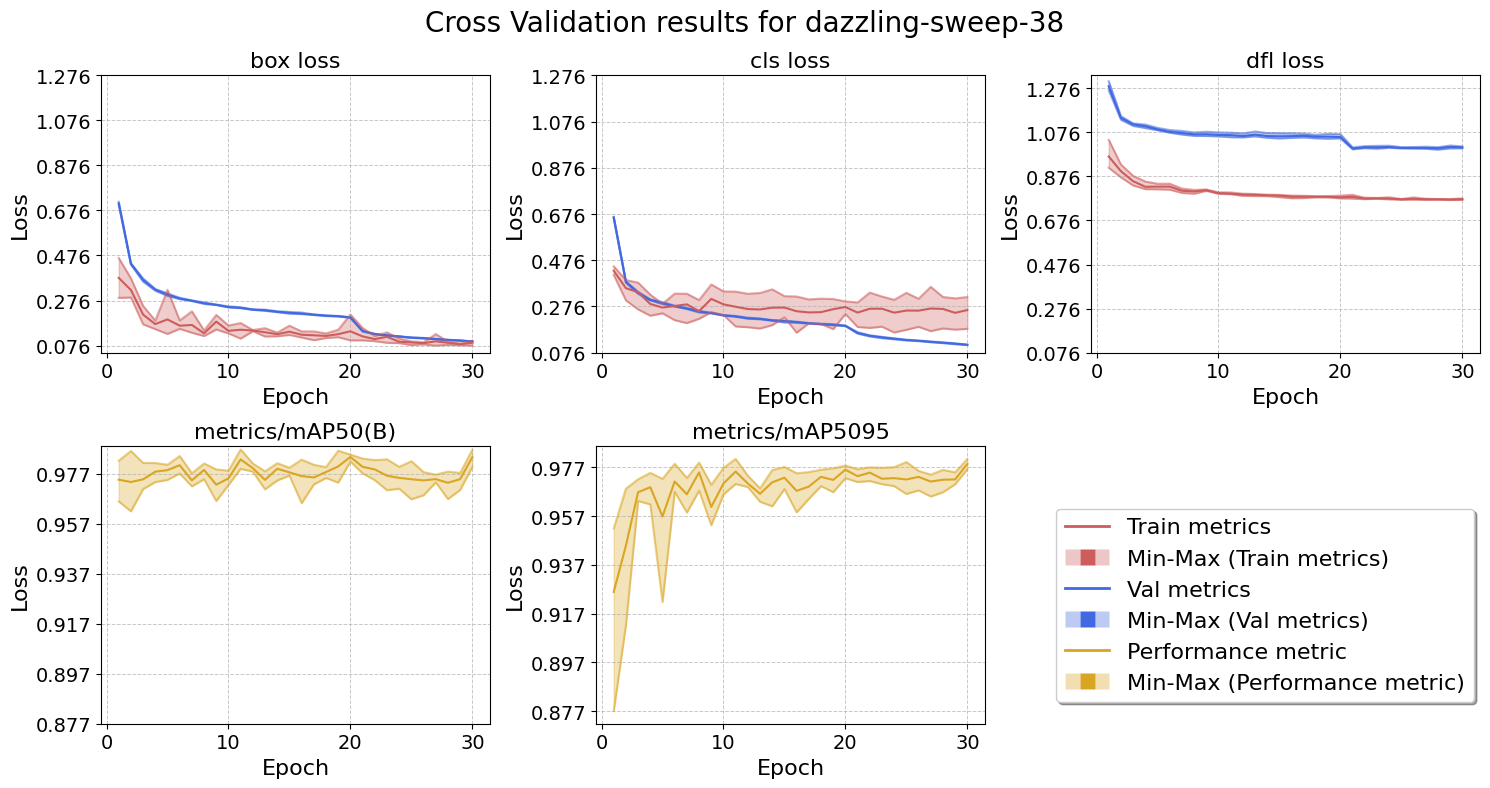

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

fig, ax = plt.subplots(2, 3, figsize=(15, 8))  # Create 2x3 grid
fig.suptitle(f"Cross Validation results for dazzling-sweep-38", fontsize=20)
ax = ax.flatten()  # Flatten the 2D array to simplify indexing

for j, df_list in enumerate(data_frames):
    c = 'royalblue' if j == 0 else 'indianred'  # Assign color per data frame list
    
    for i, df in enumerate(df_list):
        if i < 6:
            if i < 3:
                c = 'royalblue'
            else:
                c = 'indianred'
            i = i % 3
            sns.lineplot(data=df, x='Epoch', y='value_mean', color=c, ax=ax[i])
            sns.lineplot(data=df, x='Epoch', y='max_mean', color=c, alpha=0.5, ax=ax[i])
            sns.lineplot(data=df, x='Epoch', y='min_mean', color=c, alpha=0.5, ax=ax[i])
            
            ax[i].fill_between(df['Epoch'], df['max_mean'], df['min_mean'], color=c, alpha=0.3)
            ax[i].set_title(f"{df['loss_type'].iloc[0].split('/')[-1]} loss", fontsize=16)
            ax[i].set_xlabel('Epoch', fontsize=16)
            ax[i].set_ylabel('Loss', fontsize=16)
            ax[i].tick_params(axis='both', which='major', labelsize=14)
            ax[i].grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
            # set y-ticks to be the same for all subplots
            ax[i].set_yticks(np.arange(min_y_tikz_metric, max_y_tikz_metric, 0.2))
            # ax[i].get_legend().remove()
        else:
            i = i-3
            sns.lineplot(data=df, x='Epoch', y='value_mean', color='goldenrod', ax=ax[i])
            sns.lineplot(data=df, x='Epoch', y='max_mean', color='goldenrod', alpha=0.5, ax=ax[i])
            sns.lineplot(data=df, x='Epoch', y='min_mean', color='goldenrod', alpha=0.5, ax=ax[i])
            ax[i].fill_between(df['Epoch'], df['max_mean'], df['min_mean'], color='goldenrod', alpha=0.3)
            ax[i].set_title(f"{df['loss_type'].iloc[0]}", fontsize=16)
            ax[i].set_xlabel('Epoch', fontsize=16)
            ax[i].set_ylabel('Loss', fontsize=16)
            ax[i].tick_params(axis='both', which='major', labelsize=14)
            ax[i].grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
            # set y-ticks to be the same for all subplots
            ax[i].set_yticks(np.arange(min_y_tikz_performance, max_y_tikz_performance, 0.02))

ax[5].axis('off')  # Hide the last subplot


# Add custom legends at the bottom of the figure outside of the plot
legends = []
legends.append((mlines.Line2D([], [], color='indianred', linestyle='-', linewidth=2, label=f'Train metrics'), f'Train metrics'))
legends.append((MulticolorPatch(['indianred', 'indianred', 'indianred'], [0.35, 1, 0.35]), f'Min-Max (Train metrics)'))

legends.append((mlines.Line2D([], [], color='royalblue', linestyle='-', linewidth=2, label=f'Val metrics'), f'Val metrics'))
legends.append((MulticolorPatch(['royalblue', 'royalblue', 'royalblue'], [0.35, 1, 0.35]), f'Min-Max (Val metrics)'))

legends.append((mlines.Line2D([], [], color='goldenrod', linestyle='-', linewidth=2, label=f'Performance metric'), f'Performance metric'))
legends.append((MulticolorPatch(['goldenrod', 'goldenrod', 'goldenrod'], [0.35, 1, 0.35]), f'Min-Max (Performance metric)'))

handles, labels = zip(*legends)
fig.legend(handles, labels, handler_map={MulticolorPatch: MulticolorPatchHandler()}, loc='lower left', 
                            bbox_to_anchor=(0.7, 0.1), fancybox=True, shadow=True, ncol=1, fontsize=16)
# add space between subplots
plt.tight_layout()
fig.savefig('../../reports/figures/loss_comparison_cutout_loss.pdf', bbox_inches='tight')
plt.show()
